[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaxMitre/Redes_Neuronales_Scratch/blob/main/semana4/Underfitting_Overfitting.ipynb)

# Módulos (Dependencias)

In [ ]:
import math
import numpy as np

# Red de la clase pasada

In [ ]:
# Nuestra función de perdida (Error cuadrátio medio)
def mse(y_hat, y):
    return np.mean((y - y_hat)**2)

def d_mse(y_hat, y):
    return (1 / y_hat.shape[0]) * (1/y_hat.shape[-1]) * -2 * np.sum(y - y_hat, axis=0)

In [ ]:
def linear(x):
    return x


def d_linear(x):
    return np.ones_like(x)


def relu(x):
    return np.where(x > 0, x, 0)


def d_relu(x):
    return np.where(x > 0, 1, 0)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def d_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

In [ ]:
# Creación de nuestra clase red, con metodos "forward" para avanzar sobre nuestra red, "backward" para optimizar parámetros, "predict" para lo obvio
class NeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size):
        layer_sizes = [input_size] + hidden_sizes + [output_size]

        self.weights = []
        self.biases = []
        for i in range(len(layer_sizes) - 1):
            n_in = layer_sizes[i]
            n_out = layer_sizes[i + 1]
            self.weights.append(np.random.randn(n_in, n_out))
            self.biases.append(np.random.randn(1, n_out))
            self.tape = [None for _ in range(len(self.weights) + 1)]

        if hidden_sizes:
          self.activations = [linear] + [relu for _ in range(len(self.weights) - 1)] + [linear]
          self.d_activations = [d_linear] + [d_relu for _ in range(len(self.weights) - 1)] + [d_linear]
        else:
          self.activations = [linear] + [linear]
          self.d_activations = [d_linear] + [d_linear]

    def forward(self, x, grad=False):
        if grad and self.tape[0] is not None:
            raise ValueError("Cannot call forward with grad without calling backwards")

        if grad:
            self.tape[0] = x
        
        for i in range(len(self.weights)):
            x_hat = x @ self.weights[i] + self.biases[i]
            x = self.activations[i + 1](x_hat)
            if grad:
                self.tape[i + 1] = x_hat

        return x

    def backward(self, d_loss):
        assert d_loss.shape == self.weights[-1].shape[-1:]

        weights_grad = [None for w in self.weights]
        biases_grad = [None for b in self.biases]

        d_activation = self.d_activations[-1]
        error = d_loss * d_activation(self.tape[-1]) # (n_out) * (n_out)
        error = error.reshape(1, -1)

        for i in reversed(range(len(self.weights))):
            # error = (1, n_out)
            # tape[i] = (n_in)
            # weights[i] = (n_in, n_out)
            x = self.tape[i]
            activation = self.activations[i]
            d_activation = self.d_activations[i]

            weights_grad[i] = error * activation(x.reshape(-1, 1)) # (1, n_out) * (n_in, 1) -> (n_in, n_out) * (n_in, n_out) por broadcast -> (n_in, n_out)
            biases_grad[i] = error * 1 # derivada de los sesgos es un vector de unos, lo representamos explicitamente como 1 (uso de broadcasting)
            
            error = error @ self.weights[i].T  # (1, n_out) @ (n_out, n_in) -> (1, n_in)
            error = error * d_activation(x).reshape(1, -1) # (1, n_in) * (1, n_in)


        self.tape = [None for _ in range(len(self.weights) + 1)]

        return weights_grad, biases_grad

    def predict(self, x):
        y = self.forward(x)
        return y # la salida sería "y"

In [ ]:
def compute_analytical_gradient(model, X, Y, batch_size, num_classes):
    analytical_weights_grad = [np.zeros(w.shape) for w in model.weights]
    analytical_biases_grad = [np.zeros(b.shape) for b in model.biases]

    batches = list(zip(X, Y))
    for i in range(0, len(batches), batch_size):
        batch = batches[i : i + batch_size]
        x, y = zip(*batch)
        x = np.array(x)
        y = np.array(y)
        y_one_hot = y   # cuando no sea problema de clasificación  #  one_hot_encode(y, num_classes)   cuando sea clasificación
        y_hat = model.forward(x, grad=True)

        weights_grad, biases_grad = model.backward(d_mse(y_hat, y_one_hot))
        for l in range(len(model.weights)):
            analytical_weights_grad[l] += weights_grad[l]
            analytical_biases_grad[l] += biases_grad[l]

    for l in range(len(model.weights)):
        analytical_weights_grad[l] /= len(X)
        analytical_biases_grad[l] /= len(X)

    return analytical_weights_grad, analytical_biases_grad

In [ ]:
def stochastic_gradient_descent(model, X, Y, lr, batch_size, num_classes):
    analytical_weights_grad, analytical_biases_grad = compute_analytical_gradient(model, X, Y, batch_size, num_classes)

    running_loss = 0
    for x, y in zip(X, Y):
        # one hot encode labels
        x = x.reshape(1, -1)
        y = y.reshape(1)
        #  y_one_hot = one_hot_encode(y, num_classes)   # solo en problemas de clasificación

        # feed forward
        y_hat = model.forward(x, grad=True)

        # compute loss and its derivative
        loss = mse(y_hat, Y)
        d_error = d_mse(y_hat, Y)
        running_loss = loss

        # backpropagate the error (update gradients)
        model.backward(d_error)

        # gradient descent step
        for i in range(len(model.weights)):
            # update weights
            model.weights[i] += lr * -analytical_weights_grad[i]
            model.biases[i] += lr * -analytical_biases_grad[i]

            # reset gradients
            # model.weights_grad[i].fill(0)
            # model.biases_grad[i].fill(0)

    return running_loss / len(X)

In [ ]:
lista_1 = [1,2,3]
lista_2 = []

if lista_2:
  print('Hola')

# ¿Como podemos probar si nuestra red funciona bien?

In [ ]:
np.random.seed(20)

In [ ]:
def synthetic_data(w, b, num_examples):
    """Generar y = Xw + b + ruido"""
    X = np.random.normal(0, 1, (num_examples, len(w)))
    y = np.dot(X, w) + b
    y += np.random.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [ ]:
true_w = np.array([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 50)

In [ ]:
features.shape, labels.shape

((50, 2), (50, 1))

In [ ]:
labels

In [ ]:
model = NeuralNetwork(2, [], 1)

In [ ]:
loss_history = []

for epoch in range(500):
    loss = stochastic_gradient_descent(model, features, labels, lr=0.0001, batch_size=1 ,num_classes=1)
    loss_history.append(loss)
    if epoch % 10 == 0:
        print(f"epoch: {epoch} loss: {loss:.6f}")

epoch: 0 loss: 1.359942
epoch: 10 loss: 1.320480
epoch: 20 loss: 1.282133
epoch: 30 loss: 1.245445
epoch: 40 loss: 1.210766
epoch: 50 loss: 1.178301
epoch: 60 loss: 1.148143
epoch: 70 loss: 1.120308
epoch: 80 loss: 1.094753
epoch: 90 loss: 1.071397
epoch: 100 loss: 1.050132
epoch: 110 loss: 1.030837
epoch: 120 loss: 1.013380
epoch: 130 loss: 0.997629
epoch: 140 loss: 0.983452
epoch: 150 loss: 0.970720
epoch: 160 loss: 0.959312
epoch: 170 loss: 0.949111
epoch: 180 loss: 0.940008
epoch: 190 loss: 0.931903
epoch: 200 loss: 0.924702
epoch: 210 loss: 0.918318
epoch: 220 loss: 0.912672
epoch: 230 loss: 0.907691
epoch: 240 loss: 0.903309
epoch: 250 loss: 0.899465
epoch: 260 loss: 0.896103
epoch: 270 loss: 0.893174
epoch: 280 loss: 0.890632
epoch: 290 loss: 0.888435
epoch: 300 loss: 0.886547
epoch: 310 loss: 0.884933
epoch: 320 loss: 0.883562
epoch: 330 loss: 0.882408
epoch: 340 loss: 0.881446
epoch: 350 loss: 0.880652
epoch: 360 loss: 0.880007
epoch: 370 loss: 0.879493
epoch: 380 loss: 0.8790

In [ ]:
model.weights

[array([[ 1.92754511],
        [-3.39164459]])]

In [ ]:
model.biases

[array([[4.16063694]])]

In [ ]:
true_w = np.array([2, -3.4])
true_b = 4.2

# Generando el DataSet

Generemos 200 muestras (100 para entrenar, 100 para verificar) para adaptar una función.

In [ ]:
max_degree = 20  # Maximo grado polinomico (ORIGINAL 20)
n_train, n_test = 100, 100  # Tamaños de datos de entrenamiento y prueba (train y test)
true_w = np.zeros(max_degree) 
true_w[0: 4] = np.array([5, 1.2, -3.4, 5.6])

true_w

array([ 5. ,  1.2, -3.4,  5.6,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ])

El polinomio a ajustar lo tomaremos de la siguiente forma

$$ y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2) $$

Estamos dividiendo por los factoriales para poder tomar en cuenta valores grandes de x en los exponentes grandes.

In [ ]:
features = np.random.normal(0,1,size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
#for i in range(max_degree):
 #   poly_features[:, i] /= math.gamma(i + 1)  # Aqui utilizamos la función Gamma (como la función factorial)
# Forma (shape) de etiquetas (nuestra Y): ((n_train + n_test),)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

labels = labels.reshape(-1,1)

In [ ]:
poly_features[0]

array([1.        , 0.12527645, 0.01569419, 0.00196611, 0.00024631,
       0.00003086, 0.00000387, 0.00000048, 0.00000006, 0.00000001,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [ ]:
poly_features[:5]

array([[1.        , 0.12527645, 0.01569419, 0.00196611, 0.00024631,
        0.00003086, 0.00000387, 0.00000048, 0.00000006, 0.00000001,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [1.        , 0.9694624 , 0.93985735, 0.91115636, 0.88333183,
        0.856357  , 0.83020592, 0.80485342, 0.78027513, 0.7564474 ,
        0.73334731, 0.71095265, 0.68924186, 0.66819407, 0.64778903,
        0.62800711, 0.60882928, 0.59023709, 0.57221267, 0.55473867],
       [1.        , 1.09484953, 1.19869549, 1.31239118, 1.43687087,
        1.57315739, 1.72237062, 1.88573666, 2.06459789, 2.26042402,
        2.47482416, 2.70956006, 2.96656055, 3.24793742, 3.55600274,
        3.89328792, 4.26256443, 4.66686665, 5.10951674, 5.59415198],
       [1.        , 0.35501096, 0.12603278, 0.04474302, 0.01588426,
        0.00563909, 0.00200194, 0.00071071, 0.00025231, 0.00008957,
        0.0000318 , 0.00001129, 0.00000401, 0

In [ ]:
np.set_printoptions(suppress=True)

In [ ]:
poly_features[0,:] # los polinomicos del primer elemento

array([1.        , 0.12527645, 0.01569419, 0.00196611, 0.00024631,
       0.00003086, 0.00000387, 0.00000048, 0.00000006, 0.00000001,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [ ]:
poly_features = poly_features[:, 1:]
poly_features

array([[ 0.12527645,  0.01569419,  0.00196611, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.9694624 ,  0.93985735,  0.91115636, ...,  0.59023709,
         0.57221267,  0.55473867],
       [ 1.09484953,  1.19869549,  1.31239118, ...,  4.66686665,
         5.10951674,  5.59415198],
       ...,
       [ 0.20995587,  0.04408147,  0.00925516, ...,  0.        ,
         0.        ,  0.        ],
       [-0.51922803,  0.26959775, -0.13998271, ..., -0.00001449,
         0.00000752, -0.00000391],
       [ 0.46036719,  0.21193795,  0.09756928, ...,  0.00000187,
         0.00000086,  0.0000004 ]])

In [ ]:
# El primero es la X que utilizaremos,
# El segundo son las potencias de X
# El tercero es la Y de dicha X  (trataremos de aproximar polinomio f tal que f(X)=Y)
features[:1], poly_features[:1, :], labels[:1]

(array([[0.12527645]]),
 array([[0.12527645, 0.01569419, 0.00196611, 0.00024631, 0.00003086,
         0.00000387, 0.00000048, 0.00000006, 0.00000001, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        ]]),
 array([[5.12198602]]))

# Entrenamiento y pruebas

# Normal

Escogeremos las características polinomiales de $1$, $\,\, x $, $\,\,x^{2}/2!$, $\,\, x^{3}/3!$.

In [ ]:
model_grado3 = NeuralNetwork(3, [], 1)

In [ ]:
loss_history = []
loss_test = []

for epoch in range(1000):
    loss = stochastic_gradient_descent(model_grado3, poly_features[:n_train, :3], labels[:n_train].reshape(-1,1), lr=0.0001, batch_size=1 ,num_classes=1)

    loss_history.append(mse(labels[:n_train], model_grado3.predict(poly_features[:n_train, :3])))

    loss_test.append(mse(labels[n_train:], model_grado3.predict(poly_features[n_train:, :3])))
    if epoch % 100 == 0:
        print(f"epoch: {epoch} loss: {loss:.6f}")

epoch: 0 loss: 6.010069
epoch: 100 loss: 5.923386
epoch: 200 loss: 5.946611
epoch: 300 loss: 5.958202
epoch: 400 loss: 5.962274
epoch: 500 loss: 5.963677
epoch: 600 loss: 5.964190
epoch: 700 loss: 5.964394
epoch: 800 loss: 5.964483
epoch: 900 loss: 5.964525


In [ ]:
# Verdaderos pesos     [5, 1.2, -3.4, 5.6], el primero es el sesgo, el segundo el coeficiente de x, el tercero el de x^2,...
model_grado3.weights, model_grado3.biases

([array([[ 1.18267969],
         [-3.3905313 ],
         [ 5.60287539]])], [array([[4.99909787]])])

In [ ]:
import matplotlib.pyplot as plt

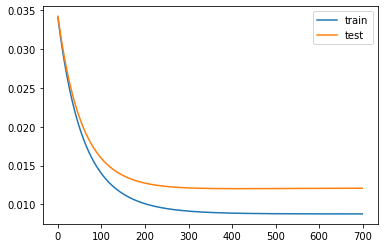

In [ ]:
plt.plot(loss_history[300:], label = "train")
plt.plot(loss_test[300:], label = "test")
plt.legend()

# Underfitting

Escogeremos solamente los elementos del primer grado para entrenar, es decir, $1$ y $x$ de las características polinomiales

In [ ]:
model_grado1 = NeuralNetwork(1, [], 1)

In [ ]:
loss_history = []
loss_test = []

for epoch in range(1000):
    loss = stochastic_gradient_descent(model_grado1, poly_features[:n_train, :1], labels[:n_train].reshape(-1,1), lr=0.0001, batch_size=1 ,num_classes=1)

    loss_history.append(mse(labels[:n_train], model_grado1.predict(poly_features[:n_train, :1])))

    loss_test.append(mse(labels[n_train:], model_grado1.predict(poly_features[n_train:, :1])))
    if epoch % 100 == 0:
        print(f"epoch: {epoch} loss: {loss:.6f}")

epoch: 0 loss: 5.931630
epoch: 100 loss: 5.939187
epoch: 200 loss: 5.949293
epoch: 300 loss: 5.951966
epoch: 400 loss: 5.952471
epoch: 500 loss: 5.952556
epoch: 600 loss: 5.952569
epoch: 700 loss: 5.952571
epoch: 800 loss: 5.952571
epoch: 900 loss: 5.952571


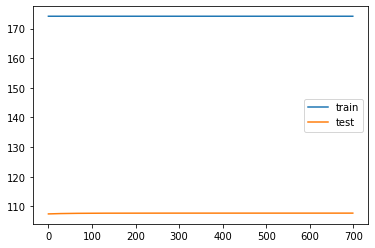

In [ ]:
plt.plot(loss_history[300:], label = "train")
plt.plot(loss_test[300:], label = "test")
plt.legend()

In [ ]:
model_grado1.weights, model_grado1.biases

([array([[19.70496029]])], [array([[1.42409968]])])

# Overfitting

Escogeremos todas las características polinomiales

In [ ]:
n=4
model_grado19 = NeuralNetwork(n, [], 1)

In [ ]:
loss_history = []
loss_test = []

for epoch in range(30000):
    loss = stochastic_gradient_descent(model_grado19, poly_features[:n_train, :n], labels[:n_train].reshape(-1,1), lr=0.000000001, batch_size=1 ,num_classes=1)

    loss_history.append(mse(labels[:n_train], model_grado19.predict(poly_features[:n_train, :n])))

    loss_test.append(mse(labels[n_train:], model_grado19.predict(poly_features[n_train:, :n])))
    

In [ ]:
mse(labels[:n_train], model_grado19.predict(poly_features[:n_train, :n]))

344.60717485304247

In [ ]:
mse(labels[n_train:], model_grado19.predict(poly_features[n_train:, :n]))

363.16212359365187

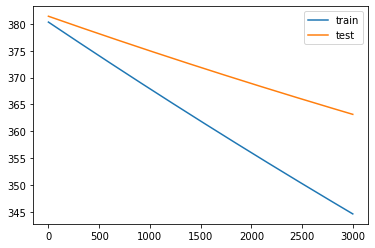

In [ ]:
plt.plot(loss_history, label = "train")
plt.plot(loss_test, label = "test")
plt.legend()